In [114]:
import os
import sys
import cv2
import math
import matplotlib.pyplot as plt
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
   
import torch
from torch.utils.data.dataloader import DataLoader 
from torchvision import transforms
    
from Net.hpatches_dataset import (HPatchesDataset, Grayscale, 
                                  Normalize, Rescale, ToTensor)
from Net.exp_env.analyze_config import cfg
from Net.utils.common_utils import *
from Net.utils.image_utils import *
from Net.utils.model_utils import sample_descriptors

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [115]:
def plot_figures(figures, nrows = 1, ncols=1):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows)
    for ind,title in zip(range(len(figures)), figures):
        axeslist.ravel()[ind].imshow(figures[title], cmap=plt.jet())
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
        
    plt.tight_layout() # optional

In [116]:
torch.manual_seed(9)
dataset = HPatchesDataset(root_path=cfg.DATASET.view.root,
                              csv_file=cfg.DATASET.view.val_show_csv,
                              transform=transforms.Compose([
                                  Grayscale(),
                                  Rescale((960, 1280)),
                                  Rescale((240, 320)),
                                  ToTensor(),
                              ]), include_sources=True)

loader = DataLoader(dataset, 1, False)


In [221]:
batch = next(loader.__iter__())
image1 = batch['image1']
image2 = batch['image2']
homo12 = batch['homo12']
homo21 = batch['homo21']

grid_size = 8

desc1 = torch.load('desc1.torch')
desc2 = torch.load('desc2.torch')

kp1 = torch.load('kp1.torch')
kp2 = torch.load('kp2.torch')

w_kp1 = warp_keypoints(kp1, homo12)
w_kp2 = warp_keypoints(kp2, homo21)

kp1_desc = sample_descriptors(desc1, kp1, grid_size)
kp2_desc = sample_descriptors(desc2, kp2, grid_size)

print(desc2[0, :, 0, 0])
desc2 = desc2.permute((0, 2, 3, 1)).view(-1, desc2.size(1))
print(desc2[0])

tensor([ 0.3168, -0.1887,  0.0298,  0.0999,  0.1537,  0.0137,  0.0428, -0.0749,
         0.3448, -0.1155,  0.1706, -0.0927,  0.1096, -0.1125, -0.0143, -0.2656,
         0.3777, -0.2521, -0.1570,  0.0888,  0.0408,  0.1177, -0.4163, -0.1249,
         0.1280, -0.0810,  0.0144, -0.1100,  0.0398,  0.2096, -0.1659, -0.0712],
       grad_fn=<SelectBackward>)
tensor([ 0.3168, -0.1887,  0.0298,  0.0999,  0.1537,  0.0137,  0.0428, -0.0749,
         0.3448, -0.1155,  0.1706, -0.0927,  0.1096, -0.1125, -0.0143, -0.2656,
         0.3777, -0.2521, -0.1570,  0.0888,  0.0408,  0.1177, -0.4163, -0.1249,
         0.1280, -0.0810,  0.0144, -0.1100,  0.0398,  0.2096, -0.1659, -0.0712],
       grad_fn=<SelectBackward>)


In [215]:
kp_grid = kp2coord(w_kp1).unsqueeze(1)
coo_grid = create_coordinates_grid(desc2.size()).view(-1, 2).unsqueeze(0)
coo_grid = coo_grid * grid_size + grid_size // 2

dist = torch.norm(kp_grid - coo_grid, dim=-1)
_, ids = dist.topk(k=4, largest=False, dim=-1)

r_ids = torch.arange(0, ids.size(0)).view(-1, 1).repeat(1, ids.size(1)).view(-1)

mask = torch.zeros_like(dist)
mask[r_ids, ids.view(-1)] = 1
mask = mask.view(-1, desc2.size(2), desc2.size(3))

torch.Size([2048, 3])


In [171]:
cv_image = torch2cv(image2)
cv_nn_cells = to_cv2_keypoint(coo_grid[0, ids[id]][:, [1, 0]])
cv_selected_kp = to_cv2_keypoint(w_kp1[id].unsqueeze(0))

cv_image = cv2.drawKeypoints(cv_image,
                             cv_nn_cells, None, color=(0, 255, 0))
cv_image = cv2.drawKeypoints(cv_image,
                             cv_selected_kp, None, color=(255, 0, 0))

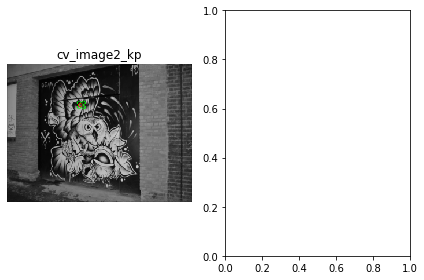

In [172]:
plot_figures({'cv_image2_kp': cv_image}, 1, 2)
plt.imsave('neg_sampling_pictures/cv_image2_kp.png', cv_image)